In [1]:
# imports 
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr


C:\Users\Ilia\anaconda3\envs\autoencoder_env\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
# loading images from a folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append(np.array(img))
    return np.array(images)

original_images = load_images_from_folder('original_images')
noised_images = load_images_from_folder('noisy_images')

print(f"Original images: {original_images.shape}, dtype: {original_images.dtype}")
print(f"Noised images: {noised_images.shape}, dtype: {noised_images.dtype}")

# Normalizing images to [0, 1] 
original_images = original_images.astype('float32') / 255.0
noised_images = noised_images.astype('float32') / 255.0

print(f"Converted Original images: {original_images.shape}, dtype: {original_images.dtype}")
print(f"Converted Noised images: {noised_images.shape}, dtype: {noised_images.dtype}")

assert original_images.shape == noised_images.shape, "Original and noised images must have the same shape." # to see that shpaes are same

Original images: (10000, 64, 64, 3), dtype: uint8
Noised images: (10000, 64, 64, 3), dtype: uint8
Converted Original images: (10000, 64, 64, 3), dtype: float32
Converted Noised images: (10000, 64, 64, 3), dtype: float32


In [3]:
# Split the dataset into training (80%), validation (10%), and testing (10%)
train_images, test_images, train_noised_images, test_noised_images = train_test_split(
    original_images, noised_images, test_size=0.2, random_state=42)

val_images, test_images, val_noised_images, test_noised_images = train_test_split(
    test_images, test_noised_images, test_size=0.5, random_state=42)

print(f"Training set: {train_images.shape}, {train_noised_images.shape}")
print(f"Validation set: {val_images.shape}, {val_noised_images.shape}")
print(f"Testing set: {test_images.shape}, {test_noised_images.shape}")


Training set: (8000, 64, 64, 3), (8000, 64, 64, 3)
Validation set: (1000, 64, 64, 3), (1000, 64, 64, 3)
Testing set: (1000, 64, 64, 3), (1000, 64, 64, 3)


In [4]:
def unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
    
    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1], axis=3)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c5)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Building and compile the simplified UNet model
input_shape = (64, 64, 3)  # because of 64x64 RGB images
unet_model = unet(input_shape)
unet_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [5]:
# Training the model for 20 epochs with a larger batch size
history = unet_model.fit(train_noised_images, train_images, epochs=25, batch_size=256, validation_data=(val_noised_images, val_images))

# Evaluating the model on the test set
test_loss, test_acc = unet_model.evaluate(test_noised_images, test_images)
print(f"Test accuracy: {test_acc}")


Epoch 1/25
32/32 [==============================] - 240s 7s/step - loss: 0.0270 - accuracy: 0.5191 - val_loss: 0.0142 - val_accuracy: 0.5725
Epoch 2/25
32/32 [==============================] - 234s 7s/step - loss: 0.0089 - accuracy: 0.5639 - val_loss: 0.0049 - val_accuracy: 0.5839
Epoch 3/25
32/32 [==============================] - 236s 7s/step - loss: 0.0042 - accuracy: 0.5900 - val_loss: 0.0034 - val_accuracy: 0.6000
Epoch 4/25
32/32 [==============================] - 235s 7s/step - loss: 0.0032 - accuracy: 0.6390 - val_loss: 0.0035 - val_accuracy: 0.6550
Epoch 5/25
32/32 [==============================] - 236s 7s/step - loss: 0.0024 - accuracy: 0.6678 - val_loss: 0.0020 - val_accuracy: 0.6843
Epoch 6/25
32/32 [==============================] - 236s 7s/step - loss: 0.0018 - accuracy: 0.7095 - val_loss: 0.0016 - val_accuracy: 0.7240
Epoch 7/25
32/32 [==============================] - 238s 7s/step - loss: 0.0015 - accuracy: 0.7585 - val_loss: 0.0012 - val_accuracy: 0.7776
Epoch 8/25
32

32/32 [==============================] - 6s 171ms/step


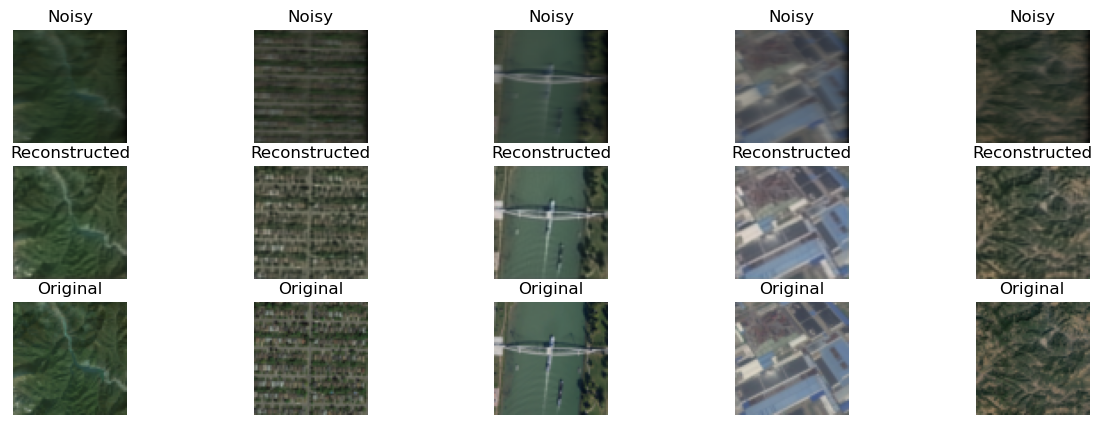

In [6]:
# Visualizing the results
def plot_image_comparison(noisy_images, original_images, predicted_images, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Noisy image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy_images[i])
        plt.title("Noisy")
        plt.axis("off")
        
        # Reconstructed image
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(predicted_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
        
        # Original image
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")
    plt.show()

# Predicting the output for the test set
predicted_images = unet_model.predict(test_noised_images)

plot_image_comparison(test_noised_images, test_images, predicted_images, num_images=5)

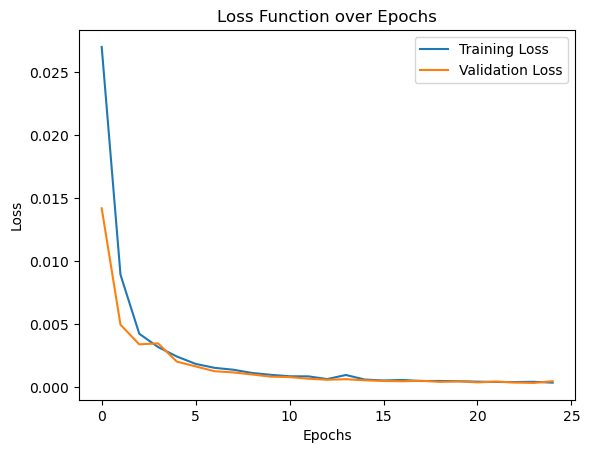

In [7]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Function over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# saving reconstructed images
save_dir = 'reconstructed_images' 
os.makedirs(save_dir, exist_ok=True)

# Predicting the output for the test set
predicted_images = unet_model.predict(test_noised_images)

# Saving the reconstructed images
for i in range(len(predicted_images)):
    reconstructed_image = (predicted_images[i] * 255).astype(np.uint8)  # Convert back to uint8
    img = Image.fromarray(reconstructed_image)
    img.save(os.path.join(save_dir, f'reconstructed_image_{i}.png'))

unet_model.save('unet_model')

32/32 [==============================] - 5s 167ms/step
INFO:tensorflow:Assets written to: unet_model\assets


INFO:tensorflow:Assets written to: unet_model\assets
